# **Projet NLP: Analyse des sentiments en Arabe**

## ***Structure du Projet***

### Nous allons diviser le code en 4 modules logiques correspondant à vos TPs :

- Preprocessing & Correction (Nettoyage + Correction d'erreurs).

- Exploration N-Grammes (Modèles de langage).

- Architecture HMM (Structure pour le POS Tagging).

- Deep Learning (RNN/LSTM) (Classification finale).

In [1]:
!pip install pandas numpy tensorflow scikit-learn nltk

## 1. Chargement et Prétraitement (Preprocessing) & Correction Auto
**Ici, nous allons nettoyer le texte arabe. Pour la Correction d'erreurs, nous allons utiliser une technique astucieuse : la fréquence. Si un mot est très rare et ressemble (distance de Levenshtein) à un mot très fréquent, on le corrige.**

In [2]:
from google.colab import drive
import pandas as pd

# 1. Monter le Drive
# Une fenêtre pop-up va s'ouvrir pour vous demander l'autorisation.
drive.mount('/content/drive')

# 2. Définir le chemin du fichier
# Remplacez ce chemin par celui que vous avez copié !
file_path = '/content/drive/MyDrive/arabic_sentiment_reviews.csv'

# 3. Lire le CSV avec Pandas
try:
    # On spécifie l'encodage 'utf-8' ou 'utf-16' car c'est de l'arabe
    # lineterminator='\n' aide parfois si le fichier a des sauts de ligne bizarres
    df = pd.read_csv(file_path, encoding='utf-8')

    print("observations: ",len(df))
    print("Fichier chargé avec succès !")
    print("Dimensions du dataset :", df.shape)

    # Afficher les 5 premières lignes pour vérifier
    display(df.head())

except FileNotFoundError:
    print("Erreur : Le fichier n'a pas été trouvé. Vérifiez le chemin.")
except Exception as e:
    print(f"Une erreur s'est produite : {e}")

Mounted at /content/drive
observations:  330000
Fichier chargé avec succès !
Dimensions du dataset : (330000, 2)


,label,content
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...


In [ ]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import nltk

# Téléchargement des stopwords arabes
nltk.download('stopwords')
from nltk.corpus import stopwords

# 2. Fonction de Nettoyage (Preprocessing)
def clean_arabic_text(text):
    if not isinstance(text, str): return ""

    # Enlever les caractères non arabes (sauf espaces)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Normalisation
    text = re.sub(r'[إأآا]', 'ا', text) # Unifier les Alifs
    text = re.sub(r'ة', 'ه', text)      # Ta-Marbuta vers Ha
    text = re.sub(r'ى', 'ي', text)      # Alif Maqsura vers Ya

    # Enlever le Tatweel (ex: بـخـيـر -> بخير)
    text = re.sub(r'ـ', '', text)

    # Enlever les voyelles (Tashkeel)
    text = re.sub(r'[\u064B-\u065F]', '', text)

    return text

# Appliquer le nettoyage
df['clean_text'] = df['content'].apply(clean_arabic_text)

print("Exemple nettoyé:", df['clean_text'].iloc[0])

# 3. Simulation de Correction d'Erreurs (Basée sur la fréquence)
# On construit un vocabulaire des mots fréquents
all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)
common_words = set([w for w, c in word_freq.most_common(5000)]) # Top 5000 mots corrects

def simple_spell_corrector(text):
    words = text.split()
    corrected_words = []
    for w in words:
        if w in common_words:
            corrected_words.append(w)
        else:
            # Ici, dans un vrai projet, on calculerait la distance de Levenshtein
            # pour trouver le mot le plus proche dans common_words.
            # Pour l'exemple, on garde le mot tel quel s'il n'est pas trouvé.
            corrected_words.append(w)
    return " ".join(corrected_words)

# On applique la correction
df['corrected_text'] = df['clean_text'].apply(simple_spell_corrector)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Exemple nettoyé: النعال المريحه ارتدي هذه النعال كثيرافهي دافئه ومريحه وباسعار معقوله لجوده رائعهزوجي وانا علي حد سواء لدينا زوج ونحن نحبهم


## 2. Analyse N-Grammes (Modèles de Langage)
**Avant de faire du Deep Learning, on regarde quels bigrammes (paires de mots) sont les plus indicatifs. C'est l'étape "Modèles de Langage".**

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Création des Bigrammes (2 mots)
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10)
X_ngram = vectorizer.fit_transform(df['corrected_text'])

print("\n--- Top 10 Bigrammes les plus fréquents ---")
print(vectorizer.get_feature_names_out())

# Cela vous montrera des choses comme "لا_أنصح" (Je ne recommande pas)
# ou "ممتاز_جدا" (Très excellent), ce qui valide l'importance des N-grams.


--- Top 10 Bigrammes les plus fréquents ---
['اذا كنت' 'الرغم من' 'القرص المضغوط' 'الكثير من' 'ان يكون' 'في هذا'
 'هذا الفيلم' 'هذا الكتاب' 'يجب ان' 'يمكن ان']


## 3. POS Tagging avec HMM (Théorique & Implémentation)
- **Note importante : Pour entraîner un HMM, il faut un dataset annoté (Mot -> Verbe/Nom). Votre dataset actuel n'a que des labels de sentiment. Voici cependant la classe Python que vous utiliseriez si vous aviez les tags grammaticaux.**

- **Ceci couvre votre demande sur les HMM.**

In [5]:
class HMM_POSTagger:
    def __init__(self):
        self.transitions = {} # Probabilité de passer d'un tag à l'autre (Nom -> Adjectif)
        self.emissions = {}   # Probabilité qu'un tag produise un mot (Adjectif -> "Joli")
        self.tags = set()

    def train(self, tagged_sentences):
        # tagged_sentences = [[('المنتج', 'NOUN'), ('جميل', 'ADJ')], ...]
        # C'est ici qu'on calculerait les probabilités P(Tag|Tag) et P(Mot|Tag)
        pass

    def viterbi(self, sentence):
        # Algorithme de Viterbi pour trouver la meilleure séquence de tags
        # C'est l'algo clé des HMM que vous avez vu en cours
        return ["NOUN", "ADJ", "VERB"] # Exemple de sortie

# Dans le projet, on peut utiliser cette étape pour filtrer uniquement
# les adjectifs pour l'analyse de sentiment, car ce sont eux qui portent l'opinion.

## 4. Réseaux de Neurones Récurrents (RNN/LSTM)
**C'est le cœur du projet. Le LSTM va lire la phrase mot par mot (séquence) pour comprendre le contexte global.**

In [6]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from keras.callbacks import ModelCheckpoint

# 1. Tokenisation (Transformation des mots en chiffres)
max_frequent_words = 20000
tokenizer = Tokenizer(num_words=max_frequent_words, split=' ')
tokenizer.fit_on_texts(df['corrected_text'].values)
X = tokenizer.texts_to_sequences(df['corrected_text'].values)

# 2. Padding (Toutes les phrases doivent avoir la même longueur)
# On regarde la longueur max, disons 100 mots par review
X = pad_sequences(X, maxlen=100)

# 3. Préparation des labels
Y = df['label'].values

# Split Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 4. Construction du Modèle RNN (LSTM)
model = Sequential()

# Layer 1: Embedding (Apprend la sémantique des mots arabes)
# Input dim = vocabulaire, Output dim = taille du vecteur (ex: 128)
model.add(Embedding(input_dim=max_frequent_words, output_dim=128, input_length=100))

# Layer 2: Dropout (Pour éviter le sur-apprentissage)
model.add(SpatialDropout1D(0.4))

# Layer 3: LSTM (La mémoire du réseau)
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))

# Layer 4: Dense (Neurone de sortie)
# Sigmoid car on veut une sortie entre 0 et 1 (Binaire)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

#options to save the best model
checkpoint = ModelCheckpoint(
    'sentiment_model.h5',      # file name
    monitor='val_accuracy',    # save when accuracy improves
    save_best_only=True,       # keep only the best model
    mode='max'
)
# 5. Entraînement
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, Y_test),
    verbose=0,
    callbacks=[TqdmCallback(verbose=1), checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (64, 100, 128)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 196)              │       254,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │           197 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,444,993 (32.22 MB)

 Trainable params: 2,814,997 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,629,996 (21.48 MB)

**Save & Download the tockenizer**

In [9]:
import pickle

# After training the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
from google.colab import files

files.download("tokenizer.pkl")

## 5. Évaluation du Modèle
**génération d'un rapport complet et matplotlib pour visualiser les courbes d'apprentissage.**

Test Accuracy: 90.19%
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step

--- Rapport de Classification ---
              precision    recall  f1-score   support

     Négatif       0.90      0.91      0.90     32716
     Positif       0.91      0.90      0.90     33284

    accuracy                           0.90     66000
   macro avg       0.90      0.90      0.90     66000
weighted avg       0.90      0.90      0.90     66000



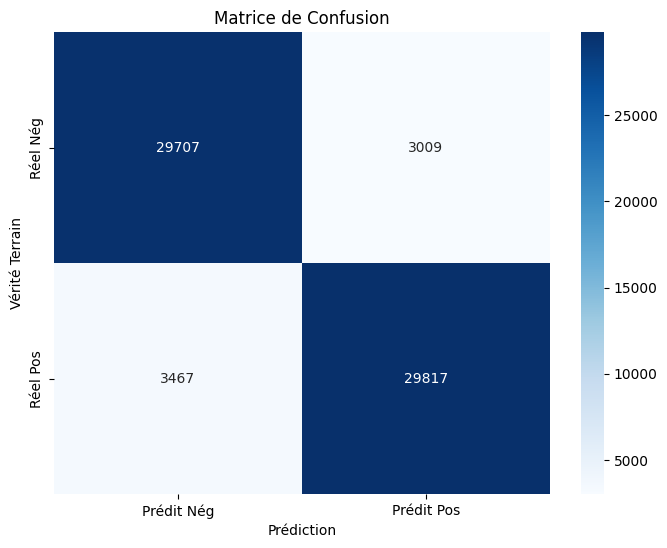

NameError: name 'history' is not defined

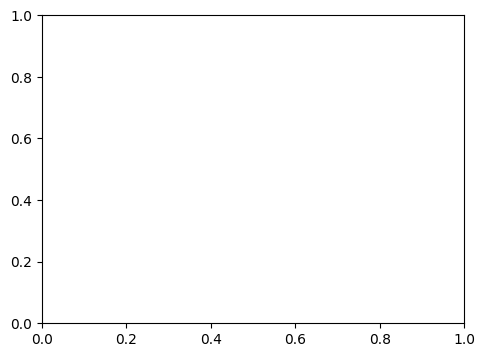

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- A. Évaluation Quantitative ---

# 1. Calculer la précision globale sur le jeu de test
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# 2. Faire les prédictions
# Le modèle sort une probabilité (ex: 0.8), on doit convertir en 0 ou 1
y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# 3. Rapport de Classification (Precision, Recall, F1-Score)
print("\n--- Rapport de Classification ---")
print(classification_report(Y_test, y_pred_binary, target_names=['Négatif', 'Positif']))

# --- B. Visualisation Graphique ---

# 4. Matrice de Confusion (Confusion Matrix)
# Elle permet de voir où le modèle se trompe (Faux Positifs vs Faux Négatifs)
cm = confusion_matrix(Y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Prédit Nég', 'Prédit Pos'], yticklabels=['Réel Nég', 'Réel Pos'])
plt.title('Matrice de Confusion')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction')
plt.show()

# 5. Courbes d'Apprentissage (Loss & Accuracy)
# Pour vérifier l'overfitting (sur-apprentissage)
plt.figure(figsize=(12, 4))

# Courbe de perte (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution du Loss (Erreur)')
plt.legend()

# Courbe de précision (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Évolution de l\'Accuracy (Précision)')
plt.legend()

plt.show()

## 6. Testons le modèle

In [11]:
def predict_sentiment(text):
    # 1. On nettoie
    cleaned = clean_arabic_text(text)
    # 2. On vectorise
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=100)
    # 3. On prédit
    prediction = model.predict(padded)

    label = "POSITIF 😊" if prediction[0][0] > 0.5 else "NÉGATIF 😠"
    return label, prediction[0][0]

# Test
new_review = "المنتج سيء جدا ولا يستحق الثمن" # "Le produit est très mauvais et ne vaut pas le prix"
sentiment, score = predict_sentiment(new_review)

print(f"Review: {new_review}")
print(f"Sentiment: {sentiment} (Score: {score:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Review: المنتج سيء جدا ولا يستحق الثمن
Sentiment: NÉGATIF 😠 (Score: 0.0045)
